In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-sales-data/car_prices.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [3]:
df = pd.read_csv('/kaggle/input/vehicle-sales-data/car_prices.csv')

print(f"Dataset shape: {df.shape}")
print(df.head()) #head of dataset
print(df.dtypes) # types of values
print(df.isnull().sum()) # print null values per col


Dataset shape: (558837, 16)
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1     

In [4]:

original_size = len(df)

# rule-based filtering
df_filtered = df[
    (df['year'] >= 1990) & (df['year'] <= 2026) & # very old cars + invalid or new entries
    (df['odometer'] > 0) & (df['odometer'] <= 500_000) & # extremely rare, may be an error
    (df['sellingprice'] > 500) & (df['sellingprice'] <= 150_000) & # scrap/ invalid sales
    (df['condition'] >= 1) & (df['condition'] <= 49) #validating condition
].copy()

# statistical outlier filtering (IQR method)
Q1 = df_filtered['sellingprice'].quantile(0.01)
Q3 = df_filtered['sellingprice'].quantile(0.99)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# final price-based filtering
df_filtered = df_filtered[
    (df_filtered['sellingprice'] >= lower_bound) &
    (df_filtered['sellingprice'] <= upper_bound)
]

print(f"Original dataset: {original_size:,} rows")
print(f"After filtering: {len(df_filtered):,} rows")


Original dataset: 558,837 rows
After filtering: 540,161 rows


In [6]:
# Target sample size (10-20% of filtered data)
target_size = min(100000, int(len(df_filtered) * 0.2))

# Create stratification bins
df_filtered['year_bin'] = pd.cut(df_filtered['year'], bins=10, labels=False)
df_filtered['price_bin'] = pd.qcut(df_filtered['sellingprice'], q=10, labels=False, duplicates='drop')

# Perform stratified sampling
df_sample = df_filtered.groupby(['year_bin', 'price_bin'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(1, int(len(x) * target_size / len(df_filtered)))), random_state=RANDOM_STATE)
).reset_index(drop=True)

# Remove temporary binning columns
df_sample = df_sample.drop(['year_bin', 'price_bin'], axis=1)

print(f"Target sample size: {target_size:,}")
print(f"Actual sample size: {len(df_sample):,}")
print(f"Sampling ratio: {100*len(df_sample)/len(df_filtered):.2f}%")
# Verify distribution preservation
print("\nYear distribution comparison:")
print("Original:")
print(df_filtered['year'].value_counts(bins=5, sort=False).head())
print("\nSampled:")
print(df_sample['year'].value_counts(bins=5, sort=False).head())

Target sample size: 100,000
Actual sample size: 99,970
Sampling ratio: 18.51%

Year distribution comparison:
Original:
(1989.974, 1995.0]       690
(1995.0, 2000.0]        9158
(2000.0, 2005.0]       60930
(2005.0, 2010.0]      131733
(2010.0, 2015.0]      337650
Name: count, dtype: int64

Sampled:
(1989.974, 1995.0]      129
(1995.0, 2000.0]       1693
(2000.0, 2005.0]      11270
(2005.0, 2010.0]      24379
(2010.0, 2015.0]      62499
Name: count, dtype: int64


In [8]:
# 1. Handle missing values first
df_sample['make'] = df_sample['make'].fillna('Unknown')
df_sample['model'] = df_sample['model'].fillna('Unknown')
df_sample['body'] = df_sample['body'].fillna('Unknown')
df_sample['transmission'] = df_sample['transmission'].fillna('unknown')

# 2. Standardize make (brand) - convert to title case
df_sample['make'] = df_sample['make'].astype(str).str.strip().str.title()
print(f"Unique makes after cleaning: {df_sample['make'].nunique()}")

# 3. Standardize model - convert to title case and strip whitespace
df_sample['model'] = df_sample['model'].astype(str).str.strip().str.title()
print(f"Unique models after cleaning: {df_sample['model'].nunique()}")

# 4. Standardize and classify body types
def standardize_body_type(body):
    """Standardize body type classifications"""
    if pd.isna(body):
        return 'Other'
    
    body = str(body).lower().strip()
    
    # Coupe variations
    if 'coupe' in body or 'cpe' in body:
        return 'Coupe'
    
    # Sedan variations
    if 'sedan' in body or 'sdn' in body:
        return 'Sedan'
    
    # SUV variations
    if 'suv' in body or 'sport utility' in body:
        return 'SUV'
    
    # Truck variations
    if 'truck' in body or 'pickup' in body:
        return 'Truck'
    
    # Van variations
    if 'van' in body or 'minivan' in body:
        return 'Van'
    
    # Wagon variations
    if 'wagon' in body or 'wgn' in body:
        return 'Wagon'
    
    # Convertible variations
    if 'convertible' in body or 'conv' in body or 'cabriolet' in body:
        return 'Convertible'
    
    # Hatchback variations
    if 'hatchback' in body or 'hatch' in body:
        return 'Hatchback'
    
    # Default
    return 'Other'

df_sample['body'] = df_sample['body'].apply(standardize_body_type)
print(f"\nBody types after standardization:")
print(df_sample['body'].value_counts())

# 5. Standardize transmission
df_sample['transmission'] = df_sample['transmission'].astype(str).str.strip().str.lower()

print(f"\nMissing values after cleaning:")
print(df_sample.isnull().sum())

print(f"\nData cleaning summary:")
print(f"  - Makes standardized: {df_sample['make'].nunique()} unique brands")
print(f"  - Models standardized: {df_sample['model'].nunique()} unique models")
print(f"  - Body types reduced to standard categories")
print(f"  - Transmission values normalized")

Unique makes after cleaning: 55
Unique models after cleaning: 706

Body types after standardization:
body
Sedan          44532
SUV            25717
Other          10814
Van             5762
Hatchback       4713
Coupe           3517
Wagon           2916
Convertible     1999
Name: count, dtype: int64

Missing values after cleaning:
year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

Data cleaning summary:
  - Makes standardized: 55 unique brands
  - Models standardized: 706 unique models
  - Body types reduced to standard categories
  - Transmission values normalized


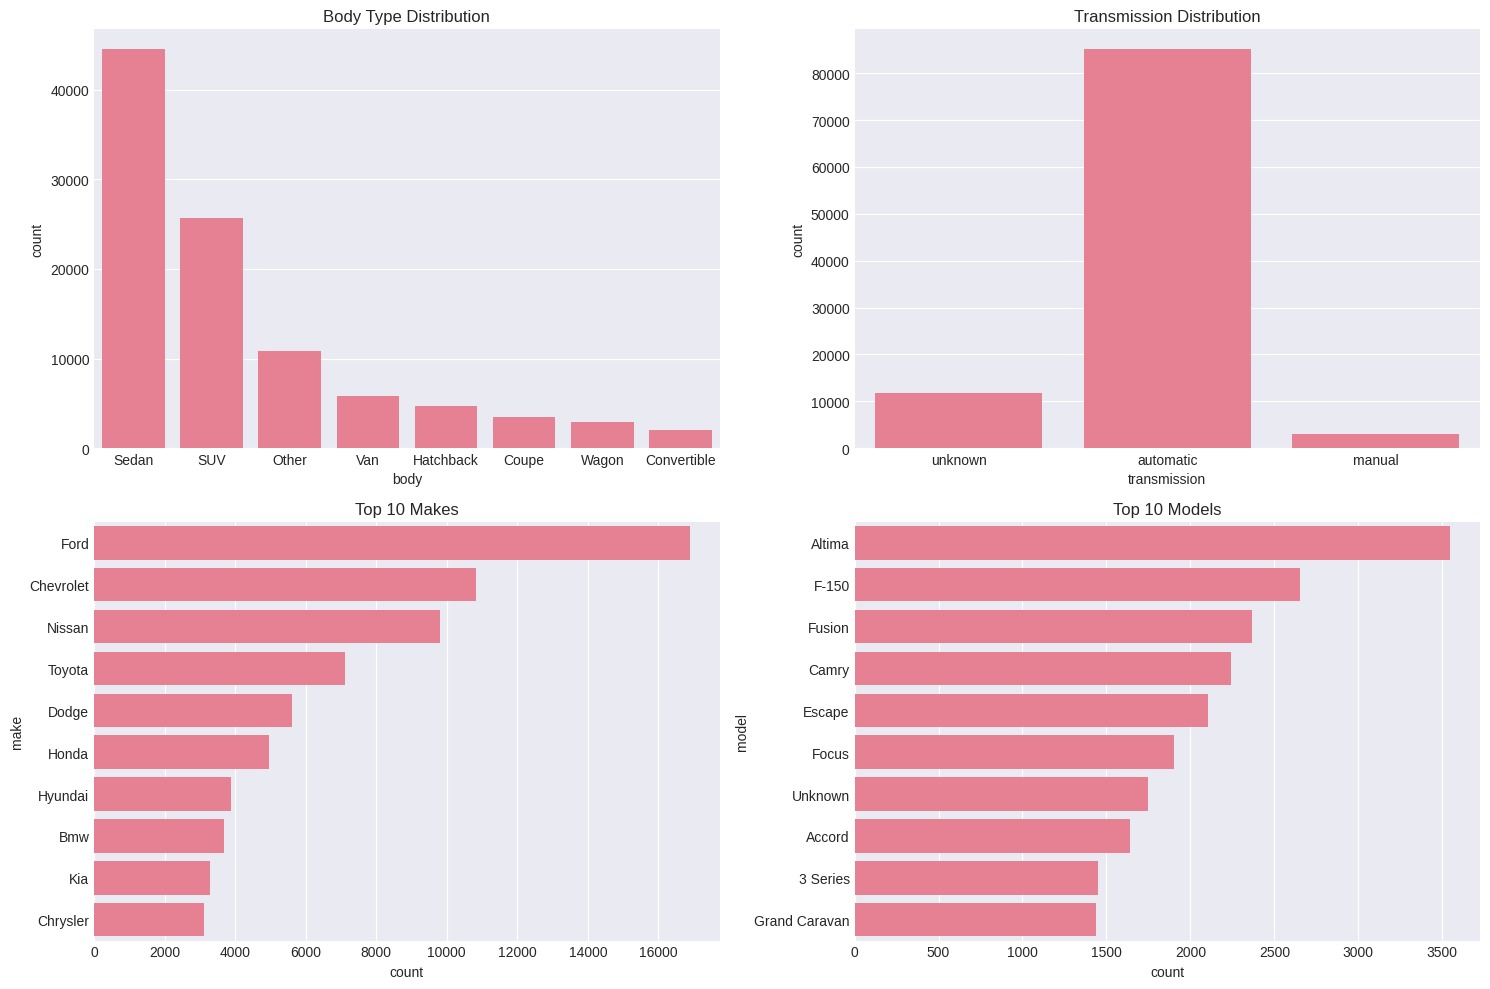

In [9]:
# visualise categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(data=df_sample, x='body', order=df_sample['body'].value_counts().index, ax=axes[0,0])
axes[0,0].set_title('Body Type Distribution')
sns.countplot(data=df_sample, x='transmission', ax=axes[0,1])
axes[0,1].set_title('Transmission Distribution')
sns.countplot(data=df_sample, y='make', order=df_sample['make'].value_counts().index[:10], ax=axes[1,0])
axes[1,0].set_title('Top 10 Makes')
sns.countplot(data=df_sample, y='model', order=df_sample['model'].value_counts().index[:10], ax=axes[1,1])
axes[1,1].set_title('Top 10 Models')
plt.tight_layout()
plt.show()

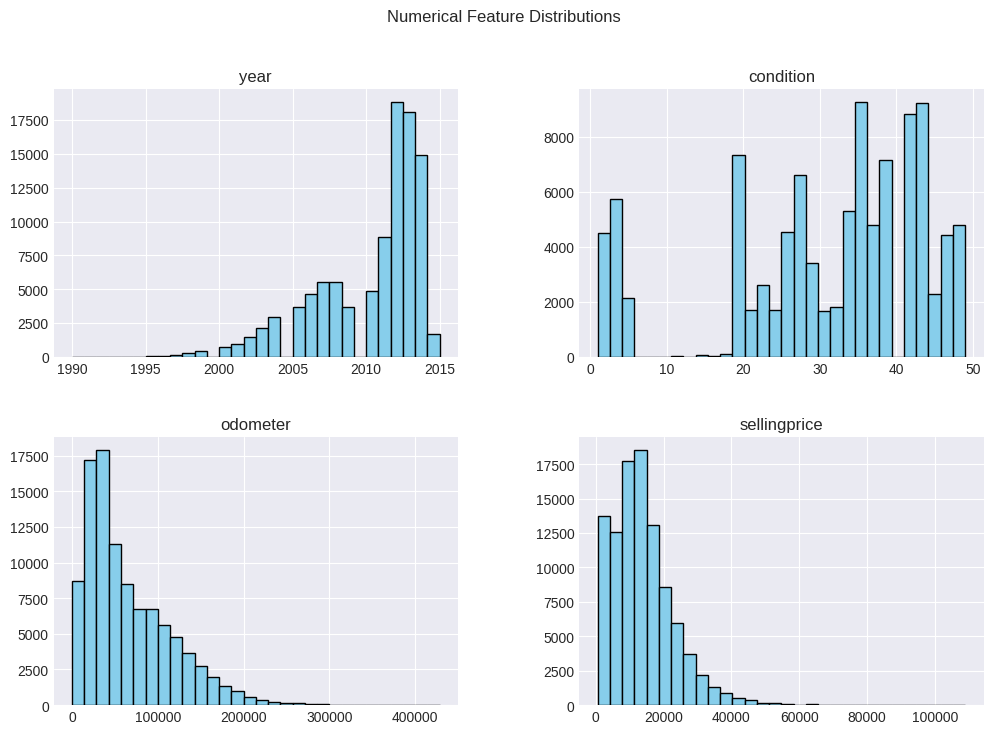

In [10]:
# numerical feature distributions
num_cols = ['year', 'condition', 'odometer', 'sellingprice']
df_sample[num_cols].hist(bins=30, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle('Numerical Feature Distributions')
plt.show()

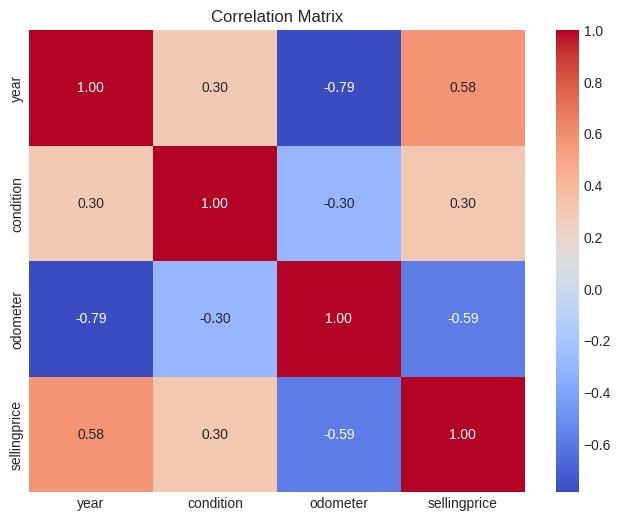

In [11]:
# correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_sample[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
categorical_cols = ['make', 'model', 'body', 'transmission']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_sample[f'{col}_encoded'] = le.fit_transform(df_sample[col])
    label_encoders[col] = le


In [14]:
# Select features for the model (excluding mmr)
feature_cols = [
    'year', 'condition', 'odometer',
    'make_encoded', 'model_encoded', 'body_encoded', 'transmission_encoded'
]

X = df_sample[feature_cols]
y = df_sample['sellingprice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Features shape: (99970, 7)
Target shape: (99970,)

Features used:
  1. year
  2. condition
  3. odometer
  4. make_encoded
  5. model_encoded
  6. body_encoded
  7. transmission_encoded


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Split ratio: 80/20")

Training set: 79,976 samples
Test set: 19,994 samples
Split ratio: 80/20


In [16]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train the model
print("\nTraining XGBoost model...")
try:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    print("Training completed successfully!")
except Exception as e:
    print(f"Error during training: {e}")
    raise

Model parameters:
  objective: reg:squarederror
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 200
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  eval_metric: rmse

Training XGBoost model...
Training completed successfully!


In [17]:
# Verify model was trained
if 'model' not in locals():
    raise NameError("Model not found!")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\nPERFORMANCE METRICS:")
print("-" * 50)
print(f"{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f}")
print(f"{'MAE ($)':<20} {train_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'RMSE ($)':<20} {train_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'MAPE (%)':<20} {train_mape:<15.2f} {test_mape:<15.2f}")
print("-" * 50)

# Cross-validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


PERFORMANCE METRICS:
--------------------------------------------------
Metric               Training        Test           
--------------------------------------------------
R² Score             0.9044          0.8928         
MAE ($)              1865.20         1952.31        
RMSE ($)             2953.20         3085.00        
MAPE (%)             19.70           20.16          
--------------------------------------------------

Performing 5-fold cross-validation...
CV R² scores: [0.88782818 0.89105679 0.88614266 0.88251455 0.88663801]
Mean CV R²: 0.8868 (+/- 0.0055)



Feature Importance Ranking:
----------------------------------------
year                      0.2488
body_encoded              0.2061
odometer                  0.1948
make_encoded              0.1559
model_encoded             0.0995
condition                 0.0843
transmission_encoded      0.0105


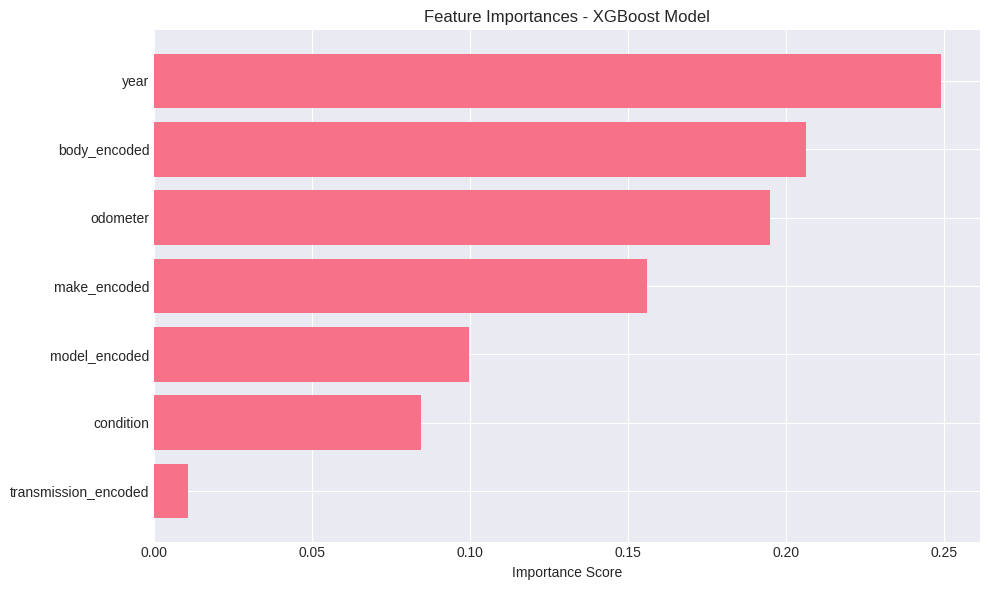

In [18]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print("-" * 40)
for idx, row in importance_df.iterrows():
    print(f"{row['feature']:<25} {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print("SAVING MODEL AND ENCODERS FOR STREAMLIT APP")

# Save the trained XGBoost model
model_filename = 'xgb_car_price_model.pkl'
joblib.dump(model, model_filename)
print(f"✓ Model saved as: {model_filename}")

# Save the label encoders dictionary
encoders_filename = 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_filename)
print(f" Label encoders saved as: {encoders_filename}")

# Also save the unique values for each categorical column for the Streamlit dropdowns
categorical_values = {
    'makes': sorted(df_sample['make'].unique().tolist()),
    'models': sorted(df_sample['model'].unique().tolist()),
    'body_types': sorted(df_sample['body'].unique().tolist()),
    'transmissions': sorted(df_sample['transmission'].unique().tolist())
}

categories_filename = 'categorical_values.pkl'
joblib.dump(categorical_values, categories_filename)
print(f" Categorical values saved as: {categories_filename}")

# Save the sample dataframe for visualizations in Streamlit
sample_data_filename = 'df_sample.pkl'
joblib.dump(df_sample, sample_data_filename)
print(f" Sample data saved as: {sample_data_filename}")

# Print summary of what was saved
print("FILES CREATED:")
print(f"1. {model_filename} - XGBoost trained model")
print(f"2. {encoders_filename} - Label encoders for categorical features")
print(f"3. {categories_filename} - Unique values for dropdowns")
print(f"4. {sample_data_filename} - Sample data for visualizations")
print("\n" + "-"*70)
print("CATEGORICAL VALUES SUMMARY:")
print(f"Total Makes: {len(categorical_values['makes'])}")
print(f"Total Models: {len(categorical_values['models'])}")
print(f"Body Types: {categorical_values['body_types']}")
print(f"Transmissions: {categorical_values['transmissions']}")
print(f"Sample Data Size: {len(df_sample):,} rows")

SAVING MODEL AND ENCODERS FOR STREAMLIT APP
✓ Model saved as: xgb_car_price_model.pkl
 Label encoders saved as: label_encoders.pkl
 Categorical values saved as: categorical_values.pkl
 Sample data saved as: df_sample.pkl
FILES CREATED:
1. xgb_car_price_model.pkl - XGBoost trained model
2. label_encoders.pkl - Label encoders for categorical features
3. categorical_values.pkl - Unique values for dropdowns
4. df_sample.pkl - Sample data for visualizations

----------------------------------------------------------------------
CATEGORICAL VALUES SUMMARY:
Total Makes: 55
Total Models: 706
Body Types: ['Convertible', 'Coupe', 'Hatchback', 'Other', 'SUV', 'Sedan', 'Van', 'Wagon']
Transmissions: ['automatic', 'manual', 'unknown']
Sample Data Size: 99,970 rows
